# Source
https://github.com/suyunu/Flow-Shop-Scheduling

https://nbviewer.jupyter.org/github/suyunu/Flow-Shop-Scheduling/blob/master/ga-fss.ipynb

In [2]:
import numpy as np
import math
import time
import random
import itertools
import queue
import pandas as pd
from IPython.display import display, Markdown
import seaborn as sns

In [3]:
predictedObjective = 732
optimalObjective = 732

def readData(data):
    f = open(data, 'r')
    jobsAndStages = f.readline().split()
    jobs = int(jobsAndStages[0])
    stages = int(jobsAndStages[1])
    
    machines = f.readline().split()
    for i in range(len(machines)):
        machines[i] = int(machines[i])

    cost = []
    for i in range(jobs):
        temp = []
        for j in range(stages):
            temp.append(0)
        cost.append(temp)
    
    for i in range(jobs):
        currentLine = f.readline().split()
        for j in range(int(len(currentLine)/2)):
            cost[i][j] = int(currentLine[2*j+1])
            
    f.close()
    return cost, jobs, stages, machines

cost, numberOfJobs, numberOfStages, numberOfMachinesInStage = readData("data4.txt")

[[39, 2, 2], [35, 1, 1], [195, 21, 8], [109, 11, 6], [93, 8, 5], [75, 6, 3], [57, 4, 3], [53, 3, 2], [33, 2, 2], [41, 2, 2]] 10 3 [1, 3, 3]


In [4]:
colors = {
    'WHITE': 30,
    'SKIN': 35,
    'BABY_PINK': 35,
    'BABY_BLUE': 35,
    'BLUE': 35,
    'GREEN': 35,
    'SILVER': 35,
    'YELLOW': 35,
    'ORANGE': 40,
    'PINK': 40,
    'RED': 40,
    'DARK_BLUE': 40,
    'GREY': 40,
    'GOLD': 40,
    'PURPLE': 40,
    'BROWN': 40,
    'BLACK': 50
}
sizes = { 'XS': 30, 'S': 20, 'M': 15, 'L': 5 }

def calculateProcTime(color=None, size=None):
    if size == None and color == None:
        print("Size and color is not set.")
        return 0
    if color != None and size == None:
        return colors[color]
    if size != None and color == None:
        return sizes[size]

    return colors[color] + sizes[size]

def createData(weight, color, size, capacity, machines):
    numberOfJobs = math.ceil(weight / capacity)
    jobs = list(list())
    for i in range(numberOfJobs):
        # procTimes = [calculateProcTime(color=color), calculateProcTime(size=size)]
        procTimes = [random.randint(5, 30), random.randint(5, 30)]
        jobs.append(procTimes)

    return jobs, len(jobs), len(procTimes), machines

cost, numberOfJobs, numberOfStages, numberOfMachinesInStage = createData(1000, 'RED', 'S', 65, [12, 4])

def createRandomPop(Npop):
    pop = []
    for i in range(Npop):
        p = list(np.random.permutation(numberOfJobs))
        while p in pop:
            p = list(np.random.permutation(numberOfJobs))
        pop.append(p)
    
    return pop

def initialization(Npop):
    return createRandomPop(Npop)

def findFirstNotBusyMachine(machines):
    for index, machine in enumerate(machines):
        if machine == False:
            return index
    
    return -1         

def calculateObj(sol):
    qTime = queue.PriorityQueue() # (time, stage, machine, job)
    machineTracker = list()
    
    # creating stages which has machine queues inside
    
    qStages = list(list())
    for i in range(numberOfStages):
        for j in numberOfMachinesInStage:
            qMachines = []
            for k in range(j):
                qMachines.append(queue.Queue())
            
            qStages.append(qMachines)
    
    # qStages = [[queue1], [queue2, queue3, queue4], [queue5, queue6, queue7]]
    # putting jobs inside first machine queue
    for i in range(numberOfJobs):
        qStages[0][0].put(sol[i])
    
    
    # creating busyMachines list to track busy machines.
    # this is actually [stage][machine]
    # [[False], [False, False, False], [False, False, False]]
    # at first no machine is busy.
    busyMachines = []
    for i in range(numberOfStages):
        busyMachines.append([])
        for j in range(len(qStages[i])):
            busyMachines[i].append(False)
    
    # initial state.
    # time = 0, job is the first element in qStages[0][0] which is queue1
    # TODO: job ve machine sayısına göre loop'ta dönmeliyiz
    for i in range(numberOfMachinesInStage[0]):
        time = 0
        job = qStages[0][0].get()
        initQTime = (time + cost[job][0], 0, i, job)
        qTime.put(initQTime)
        machineTracker.append(initQTime)
        busyMachines[0][i] = True
            
    while True:
        time, stage, machine, job = qTime.get()
        # loop through all jobs and stages - ending condition
        if job == sol[numberOfJobs-1] and stage == numberOfStages-1:
            break
        
        busyMachines[stage][machine] = False
        # if there is a job waiting to be proccessed
        if not qStages[stage][machine].empty():
            j = qStages[stage][machine].get()
            procTime = time + cost[j][stage]
            
            qTimeObj = (procTime, stage, machine, j)
            qTime.put(qTimeObj)
            machineTracker.append(qTimeObj)
            
            busyMachines[stage][machine] = True


        if stage < numberOfStages - 1:
            nextStage = stage + 1
            notBusyMachine = findFirstNotBusyMachine(busyMachines[nextStage])
            if notBusyMachine != -1:
                procTime = time + cost[job][nextStage] # stage or stage + 1 ?
                
                qTimeObj = (procTime, nextStage, notBusyMachine, job)
                qTime.put(qTimeObj)
                machineTracker.append(qTimeObj)
                
                busyMachines[nextStage][notBusyMachine] = True
            else:
                qStages[nextStage][notBusyMachine].put(job)
     
    return time, stage, machine, job

def selection(pop):
    popObj = []
    for i in range(len(pop)):
        popObj.append([calculateObj(pop[i])[0], i])
    
    popObj.sort()
    
    probabilityDistribution = []
    probabilityDistributionIndex = []
    
    for i in range(len(pop)):
        probabilityDistributionIndex.append(popObj[i][1])
        prob = (2*(i+1)) / (len(pop) * (len(pop)+1))
        probabilityDistribution.append(prob)
    
    parents = []
    for i in range(len(pop)):
        parents.append(list(np.random.choice(probabilityDistributionIndex, 2, p=probabilityDistribution)))
    
    return parents

def crossover(parents):
    # crossover points
    cp = list(np.random.permutation(np.arange(numberOfJobs-1)+1)[:2])
    
    # ordering crossover points in asc
    if cp[0] > cp[1]:
        t = cp[0]
        cp[0] = cp[1]
        cp[1] = t
    
    child = list(parents[0])
    
    # loop between crossover points
    for i in range(cp[0], cp[1]):
        child[i] = -1
    
    p = -1
    for i in range(cp[0], cp[1]):
        while True:
            p = p + 1
            if parents[1][p] not in child:
                child[i] = parents[1][p]
                break
    
    return child

def mutation(sol):
    # mutation points
    mp = list(np.random.permutation(np.arange(numberOfJobs))[:2])
    # 3, 6
    
    # sorting
    if mp[0] > mp[1]:
        t = mp[0]
        mp[0] = mp[1]
        mp[1] = t
    
    remJob = sol[mp[1]]
    
    for i in range(mp[1], mp[0], -1):
        # probability distribution = 1
        sol[i] = sol[i-1]
        
    sol[mp[0]] = remJob
    
    return sol

def elitistUpdate(oldPop, newPop):
    bestSolInd = 0
    bestSol = calculateObj(oldPop[0])[0]
    
    for i in range(1, len(oldPop)):
        tempObj = calculateObj(oldPop[i])[0]
        if tempObj < bestSol:
            bestSol = tempObj
            bestSolInd = i
            
    rndInd = random.randint(0,len(newPop)-1)    
    newPop[rndInd] = oldPop[bestSolInd]

    
    return newPop

# Returns best solution's index number, best solution's objective value and average objective value of the given population.
def findBestSolution(pop):
    bestObj, stage, machine, job = calculateObj(pop[0])
    avgObj = bestObj
    bestInd = 0
    
    for i in range(1, len(pop)):
        tempObj = calculateObj(pop[i])[0]
        avgObj = avgObj + tempObj
        if tempObj < bestObj:
            bestObj = tempObj
            bestInd = i
            
    return bestInd, bestObj, avgObj/len(pop)

In [31]:
cost

[[27, 7],
 [7, 8],
 [8, 18],
 [16, 19],
 [22, 18],
 [22, 9],
 [25, 21],
 [6, 22],
 [9, 13],
 [30, 14],
 [5, 18],
 [13, 23],
 [5, 29],
 [12, 9],
 [25, 12],
 [19, 16]]

In [6]:
# Number of population
Npop = [10, 20, 30, 40, 50]
# Probability of crossover
Pc = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# Probability of mutation
Pm = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
# Stopping number for generation
stopGeneration = [100, 1000]

# 5 * 6 * 10 * 2 = 600
# we are going to have 600 results and we will find the best one.

def genetic(Npop, Pc, Pm, stopGen):
    t1 = time.clock()
    population = initialization(Npop)
    for i in range(stopGen):
        parents = selection(population)
        childs = []

        for p in parents:
            r = random.random()
            if r < Pc:
                childs.append(crossover([population[p[0]], population[p[1]]]))
            else:
                if r < 0.5:
                    childs.append(population[p[0]])
                else:
                    childs.append(population[p[1]])
        for c in childs:
            r = random.random()
            if r < Pm:
                c = mutation(c)

        population = elitistUpdate(population, childs)
    
    bestSol, bestObj, avgObj = findBestSolution(population)
    t2 = time.clock()
    runningTime = t2 - t1
    
    return bestSol, bestObj, avgObj, runningTime

def startParameterTuning(Npop, Pc, Pm, stopGen):
    isFirst = True
    bestResult = {}
    results = []
    for n in Npop:
        for pc in Pc:
            for pm in Pm:
                for gen in stopGen: 
                    params = {
                        "Npop": n,
                        "Pc": pc,
                        "Pm": pm,
                        "stopGen": gen
                    }
                    result = genetic(n, pc, pm, gen)
                    results.append({"result": result, "params": params})
                    print(result, params)
                    if isFirst:
                        bestResult = {
                            "result": result,
                            "params": params
                        }
                    else:
                        oldBestObj = bestResult['result'][1]
                        newBestObj = result[1]
                        if newBestObj <= oldBestObj:
                            bestResult = {
                                "result": result,
                                "params": params
                            }
                            
                    isFirst = False
                    
    return bestResult, results
          

bestResult, results = startParameterTuning(Npop, Pc, Pm, stopGeneration)

C:\Users\obss\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
C:\Users\obss\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


(0, 81, 81.0, 1.7927627000003667) {'Npop': 4, 'Pc': 0.5, 'Pm': 0.01, 'stopGen': 100}
(0, 60, 60.0, 13.775235100000373) {'Npop': 4, 'Pc': 0.5, 'Pm': 0.01, 'stopGen': 1000}
(0, 55, 57.25, 1.3977036000001135) {'Npop': 4, 'Pc': 0.5, 'Pm': 0.02, 'stopGen': 100}
(1, 66, 86.5, 13.88875250000001) {'Npop': 4, 'Pc': 0.5, 'Pm': 0.02, 'stopGen': 1000}
(0, 82, 82.0, 1.4417242999998052) {'Npop': 4, 'Pc': 0.5, 'Pm': 0.03, 'stopGen': 100}
(0, 70, 70.0, 15.622617800000171) {'Npop': 4, 'Pc': 0.5, 'Pm': 0.03, 'stopGen': 1000}
(0, 79, 85.75, 1.3773848999999245) {'Npop': 4, 'Pc': 0.5, 'Pm': 0.04, 'stopGen': 100}
(0, 55, 55.0, 13.26541670000006) {'Npop': 4, 'Pc': 0.5, 'Pm': 0.04, 'stopGen': 1000}
(0, 57, 57.0, 1.334842899999785) {'Npop': 4, 'Pc': 0.5, 'Pm': 0.05, 'stopGen': 100}
(3, 44, 47.5, 15.374153400000068) {'Npop': 4, 'Pc': 0.5, 'Pm': 0.05, 'stopGen': 1000}
(0, 82, 87.5, 1.422172000000046) {'Npop': 4, 'Pc': 0.5, 'Pm': 0.06, 'stopGen': 100}
(2, 75, 87.0, 15.826175300000159) {'Npop': 4, 'Pc': 0.5, 'Pm':

(0, 45, 45.0, 11.176555400000325) {'Npop': 4, 'Pc': 0.9, 'Pm': 0.09, 'stopGen': 1000}
(1, 72, 77.5, 1.0956532999998672) {'Npop': 4, 'Pc': 0.9, 'Pm': 0.1, 'stopGen': 100}
(1, 55, 67.75, 11.36220000000003) {'Npop': 4, 'Pc': 0.9, 'Pm': 0.1, 'stopGen': 1000}
(0, 95, 95.0, 1.188495299999886) {'Npop': 4, 'Pc': 1.0, 'Pm': 0.01, 'stopGen': 100}
(0, 60, 60.0, 10.893408499999623) {'Npop': 4, 'Pc': 1.0, 'Pm': 0.01, 'stopGen': 1000}
(0, 75, 75.0, 1.2358460999998897) {'Npop': 4, 'Pc': 1.0, 'Pm': 0.02, 'stopGen': 100}
(0, 55, 55.0, 16.806293099999948) {'Npop': 4, 'Pc': 1.0, 'Pm': 0.02, 'stopGen': 1000}
(0, 65, 66.5, 1.8106576000000132) {'Npop': 4, 'Pc': 1.0, 'Pm': 0.03, 'stopGen': 100}
(1, 59, 63.5, 17.21691540000029) {'Npop': 4, 'Pc': 1.0, 'Pm': 0.03, 'stopGen': 1000}
(1, 71, 81.0, 1.1715703999998368) {'Npop': 4, 'Pc': 1.0, 'Pm': 0.04, 'stopGen': 100}
(3, 48, 51.75, 13.869078000000172) {'Npop': 4, 'Pc': 1.0, 'Pm': 0.04, 'stopGen': 1000}
(1, 70, 72.0, 1.5478304999996908) {'Npop': 4, 'Pc': 1.0, 'Pm':

(2, 51, 85.16666666666667, 16.205274299999473) {'Npop': 6, 'Pc': 0.8, 'Pm': 0.04, 'stopGen': 1000}
(2, 79, 94.83333333333333, 1.7185515000001033) {'Npop': 6, 'Pc': 0.8, 'Pm': 0.05, 'stopGen': 100}
(0, 69, 94.66666666666667, 17.77404850000039) {'Npop': 6, 'Pc': 0.8, 'Pm': 0.05, 'stopGen': 1000}
(0, 72, 110.16666666666667, 1.6880269000002954) {'Npop': 6, 'Pc': 0.8, 'Pm': 0.06, 'stopGen': 100}
(4, 77, 102.83333333333333, 16.10265680000066) {'Npop': 6, 'Pc': 0.8, 'Pm': 0.06, 'stopGen': 1000}
(3, 77, 117.83333333333333, 1.6201239000001806) {'Npop': 6, 'Pc': 0.8, 'Pm': 0.07, 'stopGen': 100}
(5, 46, 107.83333333333333, 16.19100629999957) {'Npop': 6, 'Pc': 0.8, 'Pm': 0.07, 'stopGen': 1000}
(1, 82, 116.83333333333333, 1.6265753999996377) {'Npop': 6, 'Pc': 0.8, 'Pm': 0.08, 'stopGen': 100}
(0, 51, 75.33333333333333, 16.03628739999931) {'Npop': 6, 'Pc': 0.8, 'Pm': 0.08, 'stopGen': 1000}
(4, 71, 126.33333333333333, 1.6693553999994037) {'Npop': 6, 'Pc': 0.8, 'Pm': 0.09, 'stopGen': 100}
(1, 74, 97.5,

(1, 49, 118.25, 1.3978224000002228) {'Npop': 8, 'Pc': 0.6, 'Pm': 0.1, 'stopGen': 100}
(7, 103, 122.75, 13.347402099999272) {'Npop': 8, 'Pc': 0.6, 'Pm': 0.1, 'stopGen': 1000}
(1, 76, 102.25, 1.3350780000000668) {'Npop': 8, 'Pc': 0.7, 'Pm': 0.01, 'stopGen': 100}
(2, 47, 103.0, 13.535840199999257) {'Npop': 8, 'Pc': 0.7, 'Pm': 0.01, 'stopGen': 1000}
(7, 74, 130.0, 1.3739633000004687) {'Npop': 8, 'Pc': 0.7, 'Pm': 0.02, 'stopGen': 100}
(6, 70, 120.0, 13.528756499999872) {'Npop': 8, 'Pc': 0.7, 'Pm': 0.02, 'stopGen': 1000}
(3, 63, 112.875, 1.384377499999573) {'Npop': 8, 'Pc': 0.7, 'Pm': 0.03, 'stopGen': 100}
(3, 73, 106.0, 14.318326100000377) {'Npop': 8, 'Pc': 0.7, 'Pm': 0.03, 'stopGen': 1000}
(0, 77, 108.5, 1.397157999999763) {'Npop': 8, 'Pc': 0.7, 'Pm': 0.04, 'stopGen': 100}
(3, 85, 132.25, 13.848569900000257) {'Npop': 8, 'Pc': 0.7, 'Pm': 0.04, 'stopGen': 1000}
(3, 60, 106.5, 1.3814103000004252) {'Npop': 8, 'Pc': 0.7, 'Pm': 0.05, 'stopGen': 100}
(0, 69, 119.375, 14.10502600000018) {'Npop': 8

In [34]:
def createData():
    data = [] 
    for result in results:
        Cmax = result['result'][1]
        Npop = result['params']['Npop']
        Pc = result['params']['Pc']
        Pm = result['params']['Pm']
        stopGen = result['params']['stopGen']
        item = [Cmax, Npop, Pc, Pm, stopGen]
        data.append(item)
    
    return data
    

data = createData()

df = pd.DataFrame(np.array(data),
                   columns=['Cmax', 'Npop', 'Pc', 'Pm', 'StopGen'])

df.head()

,Cmax,Npop,Pc,Pm,StopGen
0,81.0,4.0,0.5,0.01,100.0
1,60.0,4.0,0.5,0.01,1000.0
2,55.0,4.0,0.5,0.02,100.0
3,66.0,4.0,0.5,0.02,1000.0
4,82.0,4.0,0.5,0.03,100.0


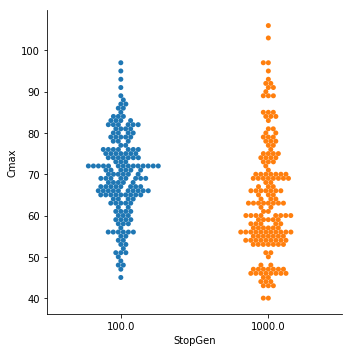

In [20]:
import matplotlib.pyplot as plt

sns.catplot(x="StopGen", y="Cmax", kind="swarm", data=df);
plt.show()

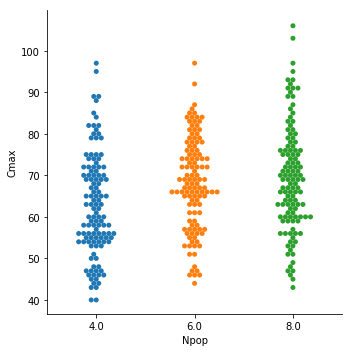

In [21]:
sns.catplot(x="Npop", y="Cmax", kind="swarm", data=df);
plt.show()

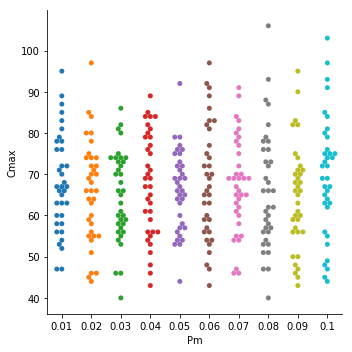

In [22]:
sns.catplot(x="Pm", y="Cmax", kind="swarm", data=df);
plt.show()

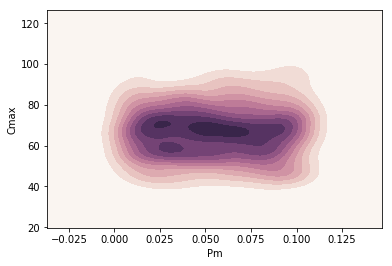

In [24]:
cmap = sns.cubehelix_palette(start=0, light=1, as_cmap=True)

# Generate and plot a random bivariate dataset

sns.kdeplot(df['Pm'], df['Cmax'], cmap=cmap, shade=True, cut=5)
plt.show()

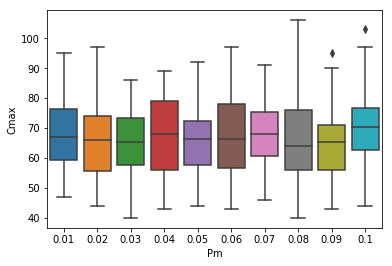

In [27]:
sns.boxplot(x="Pm", y="Cmax", data=df)

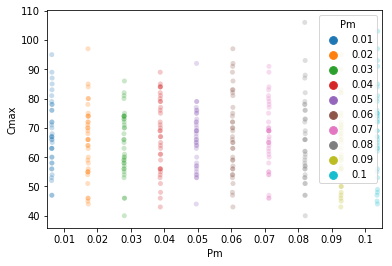

In [30]:
sns.stripplot(x="Pm", y="Cmax", hue="Pm",
              data=df, dodge=True, alpha=.25, zorder=1)

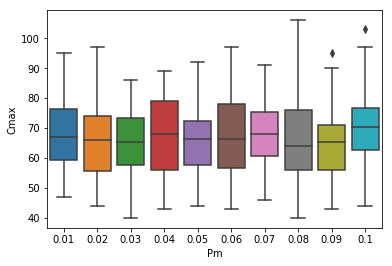

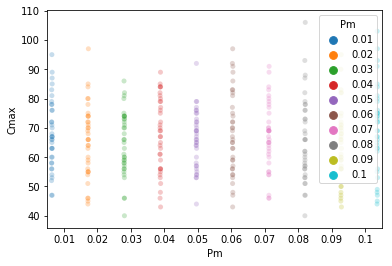

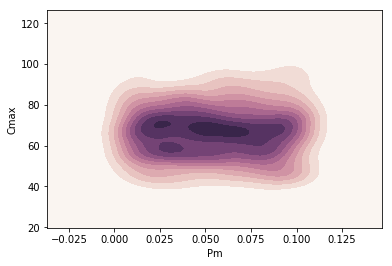

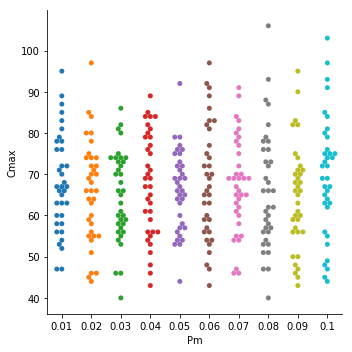

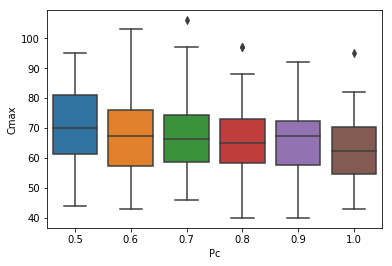

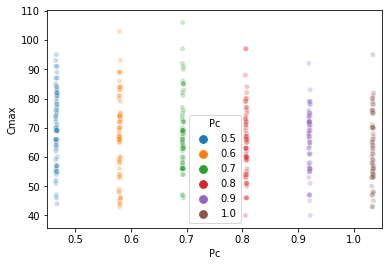

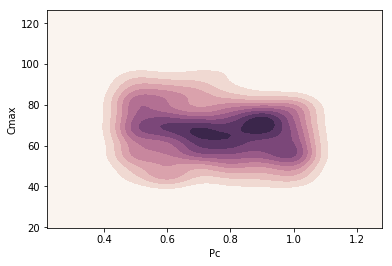

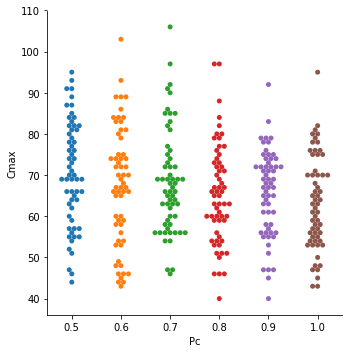

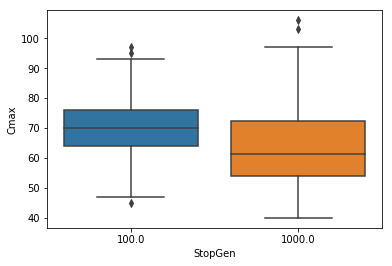

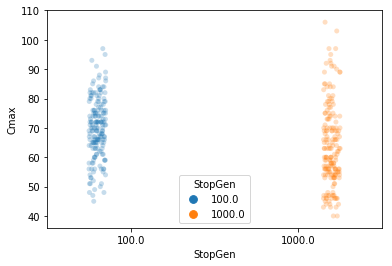

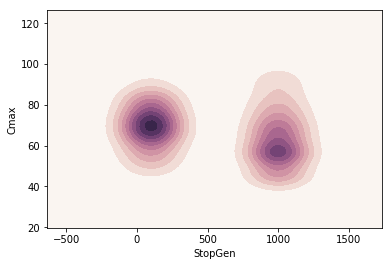

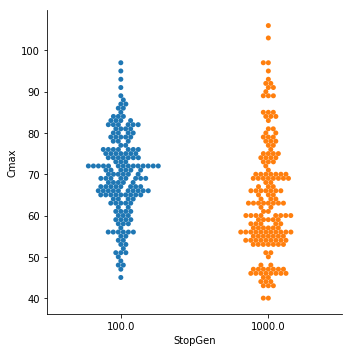

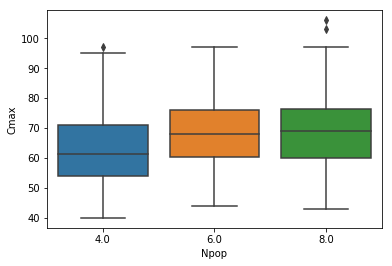

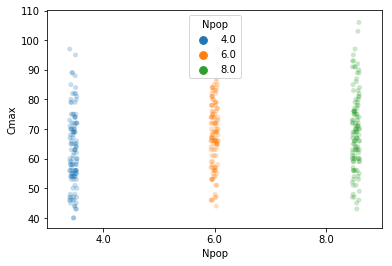

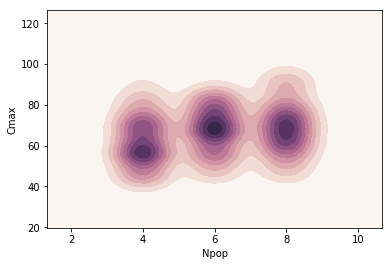

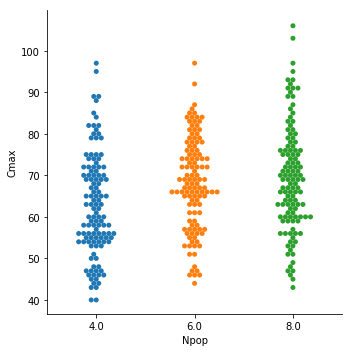

In [37]:
def createPlots():
    column_names = ['Pm', 'Pc', 'StopGen', 'Npop']
    for x in column_names:
        sns.boxplot(x=x, y="Cmax", data=df)
        plt.show()
        sns.stripplot(x=x, y="Cmax", hue=x,
              data=df, dodge=True, alpha=.25, zorder=1)
        plt.show()
        cmap = sns.cubehelix_palette(start=0, light=1, as_cmap=True)
        sns.kdeplot(df[x], df['Cmax'], cmap=cmap, shade=True, cut=5)
        plt.show()
        sns.catplot(x=x, y="Cmax", kind="swarm", data=df)
        plt.show()

createPlots()